In [4]:
# --- 1. Load, Clean, and Scale Data  ---
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load the data 
try:
    df = pd.read_csv(r'C:\Users\HP\Downloads\botswana_bank_customer_churn.csv.zip')
except:
    print("Error reloading data. Please ensure 'botswana_bank_customer_churn.csv.zip' is accessible.")
    raise

# 1.1. Drop Irrelevant/Identifying Columns
cols_to_drop = [
    'RowNumber', 'CustomerId', 'Surname', 'First Name', 'Date of Birth', 
    'Address', 'Contact Information', 'Churn Reason', 'Churn Date', 
    'Education Level', 'Preferred Communication Channel', 'Customer Segment'
]
df = df.drop(columns=cols_to_drop)

# 1.2. Separate features (X) and target (y)
X = df.drop('Churn Flag', axis=1)
y = df['Churn Flag']

# 1.3. One-Hot Encode Categorical Features
X = pd.get_dummies(X, drop_first=True)


# 1.4. APPLY FEATURE SCALING (THE FIX)
# Identify numerical columns for scaling (columns not created by one-hot encoding)
numerical_cols = [
    'Income', 'Balance', 'Credit Score', 'Customer Tenure', 'Credit History Length', 
    'Outstanding Loans', 'NumOfProducts', 'NumComplaints'
]

# Create the Scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

print("\nFeature Scaling Complete for numerical columns.")
print("First 5 Scaled Rows:")
print(X[numerical_cols].head().to_markdown(numalign="left", stralign="left"))


# 1.5. DATA SPLITTING (MUST BE DONE AFTER SCALING)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y 
)

print(f"\nData Split Complete. Training set size: {X_train.shape[0]} rows")


Feature Scaling Complete for numerical columns.
First 5 Scaled Rows:
|    | Income   | Balance   | Credit Score   | Customer Tenure   | Credit History Length   | Outstanding Loans   | NumOfProducts   | NumComplaints   |
|:---|:---------|:----------|:---------------|:------------------|:------------------------|:--------------------|:----------------|:----------------|
| 0  | 0.91393  | 1.20094   | -1.11462       | 1.67658           | 0.976753                | 1.16487             | -1.41656        | -1.58002        |
| 1  | 0.203011 | -1.30196  | 0.570202       | 1.32992           | -0.640885               | -1.174              | 0.709054        | -1.2635         |
| 2  | -1.56208 | -0.175635 | 0.884535       | -0.172239         | 0.630116                | 1.25765             | -0.708024       | 0.319148        |
| 3  | -1.36904 | 1.06008   | 1.08571        | 0.86772           | 0.167934                | -0.539014           | -1.41656        | -1.58002        |
| 4  | 0.294761 | -0.889

XGBoost not installed. Skipping this model.

--- Training Logistic Regression ---

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20309
           1       1.00      0.99      1.00      2819

    accuracy                           1.00     23128
   macro avg       1.00      1.00      1.00     23128
weighted avg       1.00      1.00      1.00     23128


--- Training Random Forest ---

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     20309
           1       0.96      0.87      0.92      2819

    accuracy                           0.98     23128
   macro avg       0.97      0.93      0.95     23128
weighted avg       0.98      0.98      0.98     23128


ALL MODEL TRAINING COMPLETE. SUMMARY & VISUALIZATIONS.
| Model               |   F1-Score |   AUC-ROC |
|:--------------------|-----------:|---------

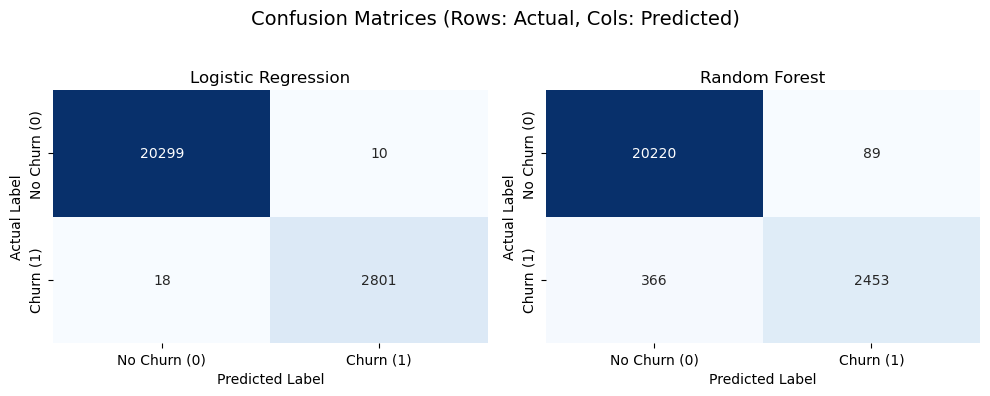

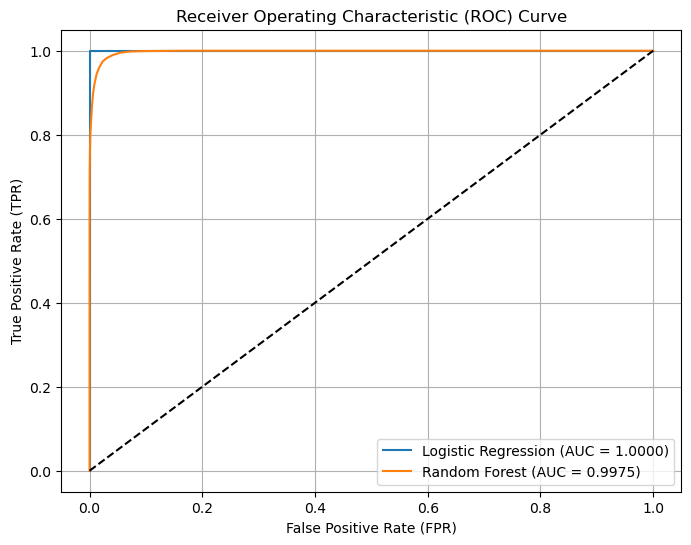

In [5]:
# --- 2. DEFINE AND TRAIN MODELS ---

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Check for XGBoost availability
try:
    from xgboost import XGBClassifier
    XGBoost_available = True
except ImportError:
    XGBoost_available = False
    print("XGBoost not installed. Skipping this model.")

# Define Models
models = {
    # Logistic Regression will now converge quickly due to scaling
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=2000),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=25) 
}

if XGBoost_available:
    models["XGBoost"] = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_estimators=50)


results = {}
confusion_matrices = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n--- Training {name} ---")
    
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    # Store results
    results[name] = {'F1-Score': f1, 'AUC-ROC': auc_roc}
    confusion_matrices[name] = cm
    
    # Print Classification Report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))


# --- 3. SUMMARY AND VISUALIZATIONS ---

print("\n" + "="*60)
print("ALL MODEL TRAINING COMPLETE. SUMMARY & VISUALIZATIONS.")
print("="*60)

# Summary of Results
results_df = pd.DataFrame(results).T
results_df.index.name = 'Model'
print(results_df.sort_values(by='AUC-ROC', ascending=False).to_markdown(floatfmt=".4f"))


# Confusion Matrices Visualization
fig, axes = plt.subplots(1, len(confusion_matrices), figsize=(5 * len(confusion_matrices), 4))
plt.suptitle('Confusion Matrices (Rows: Actual, Cols: Predicted)', fontsize=14)

for i, (name, cm) in enumerate(confusion_matrices.items()):
    ax = axes[i] if len(confusion_matrices) > 1 else axes
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        cbar=False,
        ax=ax,
        xticklabels=['No Churn (0)', 'Churn (1)'],
        yticklabels=['No Churn (0)', 'Churn (1)']
    )
    ax.set_title(name)
    ax.set_ylabel('Actual Label')
    ax.set_xlabel('Predicted Label')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# ROC Curve Visualization
plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic (ROC) Curve')

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_roc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_roc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
print("")